<a href="https://colab.research.google.com/github/Sizzin/trabalho-final-computer-vision/blob/master/object_people_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional Capstone
## Processamento de imagens aplicada a auditoria automática de vídeo baseada em modelos de deep-learning


Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas. Por meio uma trilha guiada para construir uma aplicação que tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de imagens e vídeos afim de construir uma forma de auditoria automatizada baseado em modelos de inteligência artificial.


<p align="center">
<img src="imagens-aux/example.png">
</p>


Este projeto poderá ser feita por grupos de até 4 pessoas.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Denise Maria Martins             | RM 333032      | `6IA` |
| Eduardo Luís Correia             | RM 333910      | `6IA` |
| Iury Ferreira da Silva Santos             | RM 333789      | `6IA` |
| Victor Hugo Gonçalves Gomes de Novais             | RM 333204      | `6IA` |

Por ser um projeto guiado, fique atento quando houver as marcações **Implementação** indica que é necessário realizar alguma implementação em Python no bloco a seguir onde há a inscrição ```## IMPLEMENTAR``` e **Resposta** indica que é esperado uma resposta objetiva relacionado a algum questionamento. 

**Cada grupo pode utilizar nas respostas objetivas quaisquer itens necessários que enriqueçam seu ponto vista, como gráficos, fotos e, até mesmo, trechos de código-fonte.**

Pode-se utilizar quantos blocos forem necessários para realizar determinadas implementações ou utilizá-las para justificar as respostas. Não é obrigatório utilizar somente o bloco indicado.

Ao final não se esqueça de subir os arquivos do projeto nas contas do GitHub de cada membro, ou subir na do representante do grupo e os membros realizarem o fork do projeto.

A avaliação terá mais ênfase nos seguintes tópicos de desenvolvimento do projeto:
 
1. __Modelo de identificação de idades__
2. __Modelo de identificação de gênero__
3. __Extração de faces (região de interesse)__
4. __Análise de vídeo e extração de objetos__
5. __Conclusões Finais__

Para cada item haverá uma métrica de sucesso a ser perseguida e recomendações de como atingi-la. De todo modo os grupos terão liberdade para propor abordagem _ligeiramente_ diferentes para atinger as mesmas métricas. Apenas fica vetado o uso de APIs baseadas em cloud.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

source_path = '/content/drive/My Drive/Trabalho CV/'

Mounted at /content/drive


> **Dúvidas**: clique [aqui](https://github.com/michelpf/fiap-ml-visao-computacional-capstone/issues/new) para perguntar e abrir uma _issue_.

Requisitos mínimos para execução deste projeto:

* Keras
* Scikit-learn
* Seaborn
* DLib
* OpenCv
* Pandas
* Numpy

Para verificar se possui os pacotes obrigatórios execute os comandos abaixo de importação.

In [4]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd
import dlib

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.preprocessing import image

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import ast 
from sklearn.model_selection import train_test_split

import os

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

Using TensorFlow backend.


** Importante ressaltar que precisamos do OpenCV >= 3.4.2.**

Execute o comando a baixo para verificar. Se obter versão menor que 3.4.2, instale a versão correta e depois prossiga com o projeto.

In [5]:
print(cv2.__version__)

4.1.2


## 1. O problema

Atualmente, a tecnologia disponível e acessível, sobretudo na obtenção de imagens e vídeos e em seu processamento, permite apoiar com mais ênfase atividades de auditoria e investigação de forma automatizada, sem a necessidade de uma pessoa realizar tais análises e ainda com maior acurácia.

O uso de tecnologias relacionadas a visão computacional pode contribuir para tornar mais eficiente investigações de pessoas e objetos baseadas em suas características e em seu perfil, além de tornar esta atividade mais rápida e completa.

A proposta deste projeto é apoiar uma aplicação de auditoria e investigação para automatizar a busca por regiões de interesse (objetos e determinadas pessoas) com as seguintes finalidades:

* Encontrar pessoas do gênero masculino com mais de 45 anos de idade
* Encontrar pessoas do gênero femimino com menos de 45 anos de idade
* Encontrar objetos relacionados a informática, como computadores e telefones

Uma busca manual em vídeos de vigilância é bem onerosa e pode deixar passar evidências importantes em processos investigativos.

Ainda assim, a análise humana é realizada em último caso para decidir, se dentre as evidências coletadas, quais devem seguir para investigação mais apurada e quais não. A tarefa humana é mais de validação do que exploração.

Para alcançar este objetivo iremos construir uma aplicação capaz de analisar um vídeo específico de um escritório, baseado na série de TV [_The Office_](https://pt.wikipedia.org/wiki/The_Office). A partir dele e de modelos de classificação de imagens, iremos coletar e armazenar imagens das regiões de interesse citadas para posterior análise de investigações.

Deste modo, conforme já apresentado, seguiremos com o seguinte roteiro:

* Desenvolver e construir um classificador de idade
* Desenvolver e construir um classificador de gênero
* Eleger a melhor forma de segmentar uma imagem de face
* Configurar um modelo de detecção de objetos
* Analisar um vídeo e extrair as regiões de interesse

Por fim, deverá ser realizada uma conclusão deste estudo, apresentando como foi a realização deste processo, pontos de acerto, pontos de melhoria e como poderia ser feito para aperfeiçoar os resultados.

## 2. Construção de modelos em redes neurais profundas

Nesta primeira parte, iremos construir um modelo baseado em redes neurais profundas (_deep learning_) capaz de identificar, a partir de uma imagem, qual é a idade da pessoa.

Este tipo de classificador requer um mapeamento mais profundo de cada imagem além de ser necessário um número considerável de imagens para cada idade ou faixa de idade.

Devido a necessidade de um número alto de imagens, vamos utilizar o dataset [IMDB-WIKI – 500k+ face images with age and gender labels](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki) que foi utilizado no desafio _DEX: Deep EXpectation of apparent age from a single image_.

Também foi utilizado dois excelentes artigos de Sefik Ilkin Serengil, que podem ser acessados [aqui](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras) e [aqui](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras). Esses artigos demonstram a aplicação do VGGFace para as tarefas de reconhecimento de idade e gênero. Artigos que foram ligeiramente adaptados e utilizados para o desafio.

As imagens estão disponíveis na pasta ```imagens```.

O arquivo ```age-faces-dataset.csv```, na pasta ```csv``` possui a relação de cada sujeito, contendo sua idade, localização da face, idade e referência da imagem, gênero, dentre outros campos. Com esta referência é possível associar determinado sujeito com sua face.

No conjunto de dados, a representação do gênero masculino é codificada com o valor *1* e o gênero feminino com o valor *0*.

Abra o conjunto de dados utilizando o _Pandas_. Utilize o método ```read_csv```.

In [18]:
# IMPLEMENTAR
print(source_path)
df = pd.read_csv(source_path + 'csv/age-faces-dataset.csv')

/content/drive/My Drive/Trabalho CV/


Execute o comando abaixo para apresentação de uma amostra do conjunto de dados.

In [19]:
df.head()

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth age
0           0  723671         2009  ...               NaN           1981  28
1           2  711677         2008  ...               NaN           1948  60
2           4  720044         2012  ...               NaN           1971  41
3           5  716189         2012  ...               NaN           1960  52
4           6  707745         1971  ...               NaN           1937  34

[5 rows x 11 columns]

### 2.1 Modelo de predição de idade

Antes de começarmos, avalie o conjunto de dados _Pandas_ e verifique se existe alguma otimização.
Sugerimos verificar e filtrar somente sujeitos com idade maior do que 0 e menor do que 100.

Analise o histograma e investigue com filtros do _Pandas_ para avaliar se existe necessidade de realização de algum _data cleasing_ no dataset, de acordo com a sugestão pedida.

Havendo necessidade de _data cleasing_ realize os devidos ajustes.

Vamos investigar a distribuição de idades pelo histograma.
Execute o comando abaixo.

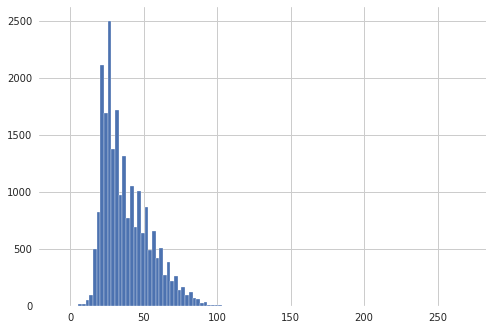

In [20]:
histograma_idade = df['age'].hist(bins=df['age'].nunique())

**Análise do gráfico:**

Considerando todos os dados, o histograma acima indica idades fora do intervalo de 0 a 100 anos, sendo necessário dessa forma realizar o *data cleasing*, isto é, aplicação de um conjunto de técnicas para detectar e remover anomalias apresentado na sequência.



De acordo com os dados de idade, vamos buscar a existência de idades inválidas.
A começar com idades menores do que 0.

In [21]:
df[df['age'] < 0]

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth age
16538       46820  715674         1952  ...               NaN           1959  -7

[1 rows x 11 columns]

Agora idades maiores do que 100.

In [22]:
df[df['age'] > 100]

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth  age
305           917  677949         1960  ...               NaN           1856  104
1658         4533  679576         1963  ...               NaN           1860  103
3282         9040  696641         2008  ...               NaN           1907  101
7019        19680  636872         2012  ...               NaN           1743  269
7124        19951  693780         2013  ...               NaN           1899  114
7520        21139  694318         2011  ...               NaN           1900  111
7607        21361  696659         2011  ...               NaN           1907  104
7894        22151  642953         1945  ...               NaN           1760  185
11725       32956  688477         2004  ...               NaN           1884  120
13955       39420  693822         2009  ...               NaN           1899  110
16220       45990  692787         2007  ...               NaN           1896  111
18464       52282  689607         1990  ...               NaN           1888  102
21478       60480  694718         2004  ...               NaN           1902  102
21951       61818  658516         2012  ...               NaN           1802  210

[14 rows x 11 columns]

Diante dos dados apresentados, realize a limpeza dos registros com idades inválidas ou de não interesse do projeto.
Para realizar a limpeza utilize da seguinte forma:

```python
df = df[df['age'] <= idade_limite_superior]
df = df[df['age'] > idade_limite_inferior]
```

Agora implemente a limpeza dos dados.

In [0]:
# IMPLEMENTAR
df = df[df['age'] <= 100]
df = df[df['age'] > 0]

Vamos executar novamente os comandos abaixo para ter certeza que os dados foram limpos.

In [24]:
len(df[df['age'] > 100]), len(df[df['age'] < 0])

(0, 0)

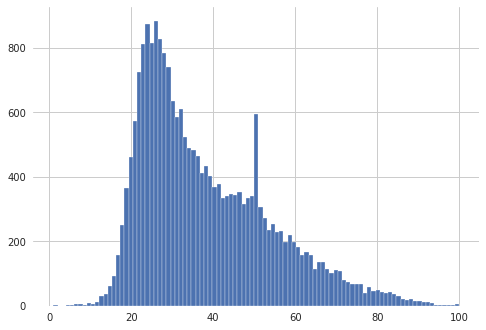

In [25]:
histograma_idade = df['age'].hist(bins=df['age'].nunique())

**Análise gráfica:**

Após o tratamento dos dados, observa-se no histograma acima uma frequência maior de pessoas com idade entre 20 e 40 anos, representando uma curva assimétrica à esquerda.

Se o resultado obtido foi 0 para ambos os filtros (exemplo (0,0)) signfica que estamos prontos para avançar.

In [0]:
df = df.sample(int(len(df) * 0.4))

In [27]:
df.size

97405

**Justificativa do método de análise utilizado:**


Inicialmente buscamos implementar as funções do trabalho utilizando o total de dados do dataset, no entanto, observamos uma alta latência memória RAM, bem como o elevado custo de processamento e atividade de hardware. A partir desse problema, uma alternativa adotada foi utilizarmos computadores com mais de 16GB de memória RAM e processadores de última geração, porém também não se mostrou viável. Por essa razão, buscamos fazer uma redução do dataset original finalizando com uma amostra de 40%, pois tentativas de redução menor não se mostraram eficientes em termos de tempo, suscetíveis a erros de análises entregando uma acurácia não aceitável.

### 2.2 Transfer learning

A técnica de _transfer learning_ é particularmente útil ao combinar modelos já validados em aplicações mais robustas, resultado de competições de grande porte.

Um benchmark nesse campo aplicado a faces é o [VGGFace](http://www.robots.ox.ac.uk/~vgg/data/vgg_face) do grupo *VGG*, o Visual Geometry Group da Univerdade de Oxford.

A arquitetura proposta pelo VGGFace é capaz de classificar faces com precisão acima de 90% em alguns trabalhos, como por exemplo [Zhang, Lingfeng & Kakadiaris, Ioannis. (2017). Local classifier chains for deep face recognition. 158-167](https://www.researchgate.net/publication/322872468_Local_classifier_chains_for_deep_face_recognition).

Este modelo tem a seguinte arquitetura.

<p align="center">
<img src="imagens-aux/vgg-face-architecture.jpg">
</p>

Observando a primeira camada, precisamos portanto padronizar as imagens de treinamento no tamanho 224 x 224 (comprimento x largura).

Os grupos que decidirem criar modelos alternativos devem explicar qual arquitetura utiliza e seus motivadores.

### 2.3 Padronização de imagens

O algoritmo abaixo normaliza as imagens para o tamanho de entrada do modelo VGGFace e também converte o valor em intenside de pixel de 0 a 255 para 0 a 1, com valores em pontos flutuantes.

Valores em ponto flutuante são melhores para se trabalhar com convergência de modelos durante os cálculos entre as camadas das redes neurais.

In [0]:
tamanho_imagem = (224, 224)
faces = []

for index, row in df.iterrows():
    image_face = image.load_img(source_path + "imagens/%s" % ast.literal_eval(row["full_path"])[0], grayscale=False, target_size=tamanho_imagem)
    image_array = image.img_to_array(image_face).reshape(1, -1)[0]
    image_array /= 255
    faces.append(image_array)

Verifique a quantidade de imagens de faces obtidas pelo conjunto de dados.

In [0]:
# IMPLEMENTAR
qtd_faces = len(faces)

In [31]:
print("O total de faces de imagens é de " + str(qtd_faces) + ".")

O total de faces de imagens é de 8855.


### 2.4 Definição do modelo

O próximo passo é a definição do número de classes. Como a definição de classes é _zero based_ sempre defina adicionando 1 ao valor final.

Exemplo, se o número de classes compreender entre idades maior do que 0 e menor ou igual a 100, teremos 100 classes, logo o número de classes de idade é 101.

In [0]:
# IMPLEMENTAR
classes_idade = 101

Uma forma de categorizarmos as classes é utilizando o modelo _one hot encode_. Onde será expressado em um array com todas as classes. A classe correspondente a um determindo registro será armazenado como o valor 1 naquela classe.

In [0]:
idades = df['age'].values
idades_classes = keras.utils.to_categorical(idades, classes_idade)

Faça um teste do _one hot encoding_. Exiba os dados do registro de índice zero do conjunto de dados.

In [34]:
idades_classes[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Em seguida, vamos adaptar o _shape_ dos dados no padrão que o framework Keras utiliza.

In [0]:
features_imagem = []
 
features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

### 2.5 Separação de dados de treinamento e validação

Para que o modelo seja robusto, é importante validar um subconjunto de amostras que não participaram do treinamento inicial.

Defina uma porcentagem, da base total, que deverá ser separa somente para a validação. Expresse o número na forma de número fracionário, por exemplo 40% equivale a 0.4.

In [0]:
# IMPLEMENTAR
porcentagem_validacao = 0.2

O método aplicado (Hold-out validation) se trata de um método simples para separação dos dados entre treinamento e teste, é o mais usado quando se trata de um dataset que apresenta uma grande quantidade de dados, permitindo comprovar que as amostras têm significância estatística para representar a população.

A seleção de 80% dos dados da amostra para treinamento permite uma representatividade do dataset, reduzindo a variância e permitindo o cálculo dos hiperparâmetros da rede neural de forma a promover uma classificação com mais assertividade. Com menos dados de treinamento as estimativas de parâmetros têm maior variação, interferindo no resultado final.

Execute o método ```train_test_split``` para realizar a divisão de cada tipo de amostra, sendo:
* ```treinamento_x``` contém os _features_ de treinamento
* ```teste_x``` contém os _features_ de validação (também é chamado de teste)
* ```treinamento_y``` contém as classes de treinamento
* ```teste_y``` contém as classes de validação

In [0]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  idades_classes, 
                                                                  test_size=porcentagem_validacao, random_state = 42)

### 2.6 Treinamento e validação

O modelo VGGFace ainda não está por padrão na biblioteca Keras. Mesmo assim, como o artigo citado anteriormente possui a arquitetura definida, podemos implementá-la manualmente.

In [38]:
#VGG-Face model
modelo = Sequential()
modelo.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(Convolution2D(4096, (7, 7), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(4096, (1, 1), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(2622, (1, 1)))
modelo.add(Flatten())
modelo.add(Activation('softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Os pesos já treinamentos podem ser baixados neste [link](https://drive.google.com/open?id=1xJY1mWULLOnK5GAGULcp_cgasVfy-e2j). Copie ele para a pasta ```pesos```.
O arquivo de pesos é o mesmo utilizado neste [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [39]:
modelo.load_weights(source_path + "pesos/vgg_face_weights.h5")

Assim como em qualquer modelo de _transfer learning_, precisamos adicionar na última camada as classes correspondentes. Deste modo, na saída da camada convulacional precisamos definir o número de classes. É o primeiro parâmetro do objeto ```Convolution2D```.

In [0]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()

# IMPLEMENTAR
saida_modelo = Convolution2D(classes_idade, (1, 1), name='predictions')(modelo.layers[-4].output)

saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)
modelo_idade = Model(inputs=modelo.input, outputs=saida_modelo)

Este tipo de treinamento possui muitas imagens. A etapa de treinamento pode demorar até mesmo mais do que 2 horas dependendo do tipo de computador utilizado.

Apesar da demora, este desafio traz um desafio real de treinar um modelo de imagens com quantidade de exemplos adequado para as classificações requeridas.

Sugiro que após o treinamento ser realizado, salvar os novos pesos e a rede para utilizar mais adiante nas inferências.

Revise a arquitetura da rede com o comando a seguir.

In [41]:
modelo_idade.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0   

O número de *épocas* é responsável por quantas vezes o modelo percorrerá o ciclo de _foward_ e _back_ _propagation_.

Como este modelo possui muitas imagens, sugerimos um valor mínimo de 2 épocas.

In [0]:
# IMPLEMENTAR
numero_epocas = 20

**Justificativa da quantidade de épocas usadas:**


Considerando o valor mínimo de duas épocas proposto no trabalho, foi necessário executar o modelo com mais épocas buscando eliminar a situação de underfitting. O mesmo cuidado com o aumento substancial de épocas foi tomado para evitar o overfitting. Diante desse contexto, o modelo apresentou uma melhor acurácia com o número de 20 épocas.



*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```.*

In [0]:
modelo_idade.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico = modelo_idade.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7084 samples, validate on 1771 samples
Epoch 1/20
7084/7084 [==============================] - 55s 8ms/step - loss: 3.8361 - acc: 0.0418 - val_loss: 3.6112 - val_acc: 0.0615
Epoch 2/20
7084/7084 [==============================] - 45s 6ms/step - loss: 3.5790 - acc: 0.0600 - val_loss: 3.5511 - val_acc: 0.0514
Epoch 3/20
7084/7084 [==============================] - 45s 6ms/step - loss: 3.4650 - acc: 0.0798 - val_loss: 3.5303 - val_acc: 0.0519
Epoch 4/20
7084/7084 [==============================] - 45s 6ms/step - loss: 3.3368 - acc: 0.1035 - val_loss: 3.5485 - val_acc: 0.0497
Epoch 5/20
7084/7084 [==============================] - 45s 6ms/step - loss: 3.1710 - acc: 0.1402 - val_loss: 3.5642 - val_acc: 0.0553
Epoch 6/20
7084/7084 [==============================] - 45s 6ms/step - loss: 2.9794 - acc: 0.1894 - val_loss: 3.5802 - val_acc: 0.0548
Epoch 7/20
7084/7084 [========================

Armazene os valores do modelo e dos pesos para inferências futuras.

In [0]:
# Salvando o modelo no formato HDf5
modelo_idade.save(source_path + "modelos/modelo_idade.h5")
modelo_idade.save_weights(source_path + "pesos/modelo_idade_pesos.h5")

Os valores de erro e acurácia são importantes indicadores de desempenho da rede. Avaliar a tendência de subida ou descida destes parâmetros é essencial para localizar, por exemplo, prooblemas de _overfitting_ e _underfitting_. 
Com o suporte dos gráficos avalie a tendência do modelo ao logo das épocas.

In [0]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico.history['acc'])
plt.plot(historico.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

<font color="#e74c3c">**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?</font>

**Resposta:**

- Acurácia: conforme a execução das épocas, a tendência dos exemplos de treino foi positiva, tendo seu início em aproximadamente 0,05 e terminando em 0,6. O que indica que o modelo aumentou sua acurácia conforme o tempo de treinamento. Para os dados de testes, esta medida se provou aproximadamente constante durante todo o processo.
- Perda: no gráfico da perda, podemos perceber que os dados de treino têm tendência negativa, indicando que conforme o tempo estes exemplos erraram menos. Para os dados de teste, podemos perceber uma lefe tendência positiva, embora tenha se provado constante nas primeiras épocas.

Os comandos abaixo são de referência para carregar um modelo para inferências futuras.

In [43]:
# carregando o modelo no formato HDf5
modelo_idade = load_model(source_path + "modelos/modelo_idade.h5")  
modelo_idade.load_weights(source_path + "pesos/modelo_idade_pesos.h5")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Este classificador tem uma particularidade diferente quando comparado com outros classificadores.
Geralmente um classificador retorna, dado uma amostra, qual a classe mais próxima ou qual tem maior probabilidade estatística. Por exemplo, se fóssemos classificar um objeto, o retorno seria a classe correspondente àquele objeto com maior semelhança, mutualmente excludente, sendo uma única classe como resultado.

Neste caso é diferente.

Cada classe se refere a uma idade, logo, ao invés de nos basearmos na classe dominante, com maior probabilidade, podemos somar as probabilidades com cada classe e assim ter um valor de idade mais aproximado (veja na imagem abaixo do pipeline, item 5). 

É por essa razão que a acurácia do modelo, baseada somente na classe dominante é baixa.

<p align="center">
<img src="imagens-aux/pipeline.png">
</p>

Os comandos abaixo contabilizam a predição baseada na soma das probabilidades de cada classe.

In [0]:
predicoes_idade = modelo_idade.predict(teste_x)
classes_idade_saida = np.array([i for i in range(0, classes_idade)])
predicoes_agrupadas = np.sum(predicoes_idade * classes_idade_saida, axis = 1)

Deste modo, o valor da acurácia não é o melhor para avaliarmoso modelo. A uma outra forma de avaliação é utilizarmos o _Erro Médio Absoluto_.

O uso do _Erro Médio Absoluto_ foi integralmente aplicado de acordo com este [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [0]:
erro_medio_absoluto = 0
atual_media = 0

for i in range(0 ,predicoes_agrupadas.shape[0]):
    predicao = int(predicoes_agrupadas[i])
    atual = np.argmax(teste_y[i])
    erro_abs = abs(predicao - atual)
    atual_media = atual_media + atual
    erro_medio_absoluto += erro_abs

In [46]:
erro_medio_absoluto /= predicoes_agrupadas.shape[0]
 
print("Erro médio absoluto (+/-): ", erro_medio_absoluto, " anos")
print("Exemplos analisados: ",predicoes_agrupadas.shape[0])

Erro médio absoluto (+/-):  4.969508752117448  anos
Exemplos analisados:  1771


> **Critério de sucesso:** com base nas amostras de teste, o erro absoluto precisa ser não mais do que (+/-) 8.

### 2.7 Avaliação final

Vamos analisar um conjunto de 6 imagens e verificar a coerência do modelo.
Antes precisamos contruir uma função, a ```carregarImagem``` para padronizar a imagem, redimensionando para o formato do modelo e normalizando a intensidade dos pixels.

In [0]:
def carregarImagem(caminho):
    imagem = image.load_img(caminho, target_size=(224, 224))
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    imagem /= 255
    return imagem

Para cada imagem de testes já separadas no diretório ```testes```, vamos padronizá-la.

In [0]:
caminho_imagem_1 = source_path + "testes/teste-1.jpg"
imagem_1_pad = carregarImagem(caminho_imagem_1)

Executar a inferência para obter sua predição.

In [0]:
predicao_1 = modelo_idade.predict(imagem_1_pad)

E, finalmente, somar as classes para a classificação mais exata.

In [0]:
idade_agrupada_1 = np.round(np.sum(predicao_1 * classes_idade_saida, axis = 1))

A função abaixo é para exibirmos no gráfico. Como elas estão com tamanhos diferentes, vamos também redimensioná-las para o padrão do moodeo, apenas por convenção, poderia ser outro tamanho.

In [0]:
imagem_1 = image.load_img(caminho_imagem_1, target_size=(224, 224))

Agora, faremos para todas as outras imagens.

In [0]:
caminho_imagem_2 = source_path + "testes/teste-2.png"
imagem_2_pad = carregarImagem(caminho_imagem_2)
imagem_2 = image.load_img(caminho_imagem_2, target_size=(224, 224))
predicao_2 = modelo_idade.predict(imagem_2_pad)
idade_agrupada_2 = np.round(np.sum(predicao_2 * classes_idade_saida, axis = 1))

caminho_imagem_3 = source_path + "testes/teste-3.png"
imagem_3_pad = carregarImagem(caminho_imagem_3)
imagem_3 = image.load_img(caminho_imagem_3, target_size=(224, 224))
predicao_3 = modelo_idade.predict(imagem_3_pad)
idade_agrupada_3 = np.round(np.sum(predicao_3 * classes_idade_saida, axis = 1))

caminho_imagem_4 = source_path + "testes/teste-4.png"
imagem_4_pad = carregarImagem(caminho_imagem_4)
imagem_4 = image.load_img(caminho_imagem_4, target_size=(224, 224))
predicao_4 = modelo_idade.predict(imagem_4_pad)
idade_agrupada_4 = np.round(np.sum(predicao_4 * classes_idade_saida, axis = 1))

caminho_imagem_5 = source_path + "testes/teste-5.png"
imagem_5_pad = carregarImagem(caminho_imagem_5)
imagem_5 = image.load_img(caminho_imagem_5, target_size=(224, 224))
predicao_5 = modelo_idade.predict(imagem_5_pad)
idade_agrupada_5 = np.round(np.sum(predicao_5 * classes_idade_saida, axis = 1))

caminho_imagem_6 = source_path + "testes/teste-6.png"
imagem_6_pad = carregarImagem(caminho_imagem_6)
imagem_6 = image.load_img(caminho_imagem_6, target_size=(224, 224))
predicao_6 = modelo_idade.predict(imagem_6_pad)
idade_agrupada_6 = np.round(np.sum(predicao_6 * classes_idade_saida, axis = 1))

Exibindo as imagens.

O resultado da idade é índice 0 do objeto ```idade_agrupada```.

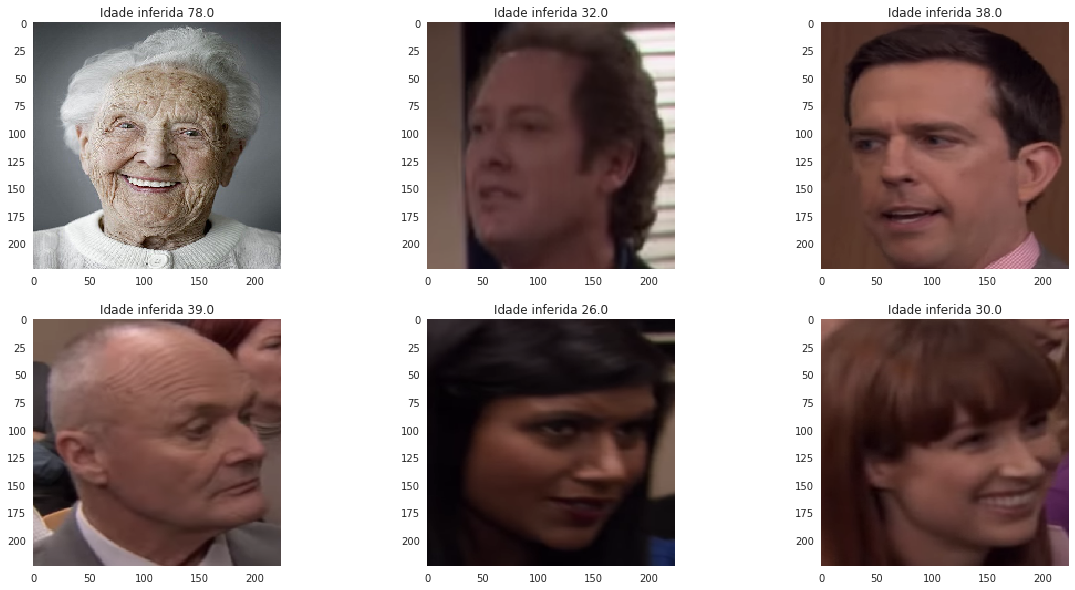

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Idade inferida " + str(idade_agrupada_1[0]))
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Idade inferida " + str(idade_agrupada_2[0]))
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Idade inferida " + str(idade_agrupada_3[0]))
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Idade inferida " + str(idade_agrupada_4[0]))
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Idade inferida " + str(idade_agrupada_5[0]))
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Idade inferida " + str(idade_agrupada_6[0]))
plt.imshow(imagem_6)

plt.show()

Analise se as idades estão coerentes com as imagens. Se estiver muito fora, avalie aumentar o número de épocas, por exemplo.

Agora vamos implementar a função que retornará a idade a partir de uma imagem de entrada já padronizada (assuma que foi padronizada por uma função como a ```carregarImagem```. Assegure que a função retorne o valor da idade inferida em valor numérico, sem valor fracionário, somente inteiro.

In [0]:
def predizerIdade(imagem):
    pred = modelo_idade.predict(imagem)
    idade = np.round(np.sum(pred * classes_idade_saida, axis = 1))
    return int(idade[0])

In [55]:
predizerIdade(carregarImagem(caminho_imagem_6))

30

## 3. Modelo de predição de gênero biológico

A base utilizada será a mesma que aplicamos no modeo de idade. Nesse o caso o modelo terá uma tarefa mais fácil, pois ao invés de aproximidamente 100 classes vamos ter somente 2 classes, uma cada definir o gênero masculino e outra para o gênero feminino. 

### 3.1 Definição do modelo
Vamos começar definindo o número de classes.

In [0]:
# IMPLEMENTAR
num_classes_genero = 2

Transformando os valores do conjunto de dados em _one hot enconding_ para definição dos gêneros.

In [0]:
generos = df['gender'].values
generos_classes = keras.utils.to_categorical(generos, num_classes_genero)

Como para ambos os modelos, de idade e gênero, utilizamos a mesma base de _transfer learning_ do VGGFace, vamos reutilizá-la também neste modelo.

In [0]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()
saida_modelo = Convolution2D(num_classes_genero, (1, 1), name='predictions')(modelo.layers[-4].output)
saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)

modelo_genero = Model(inputs=modelo.input, outputs=saida_modelo)

### 3.2 Separação de dados de treinamento e validação

É recomendavel manter a mesma porcentagem do modelo anterior para dividir os dados de treinamento e validação.

In [0]:
#IMPLEMENTAR
porcentagem_validacao = 0.2

In [0]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  generos_classes, 
                                                                  test_size=porcentagem_validacao,
                                                                  random_state=42)

### 3.3 Treinamento e validação

A seguir iremos treinar o modelo para classificação de gêneros.
De forma semelhante realizada anteriormente, é necessário definir o número de épocas para esta etapa. Recomendamos um valor mínimo de 2.

In [0]:
# IMPLEMENTAR
numero_epocas = 20

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```*.

Este modelo é mais simples por ter menos classes, logo podemos assumir um ```batch_size``` maior que o anterior.

In [0]:
modelo_genero.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico_genero = modelo_genero.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=64)

Train on 7084 samples, validate on 1771 samples
Epoch 1/20
7084/7084 [==============================] - 40s 6ms/step - loss: 0.2930 - acc: 0.8820 - val_loss: 0.1452 - val_acc: 0.9435
Epoch 2/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.1217 - acc: 0.9571 - val_loss: 0.1126 - val_acc: 0.9627
Epoch 3/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.0826 - acc: 0.9716 - val_loss: 0.0887 - val_acc: 0.9712
Epoch 4/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.0629 - acc: 0.9805 - val_loss: 0.0852 - val_acc: 0.9791
Epoch 5/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.0528 - acc: 0.9836 - val_loss: 0.0799 - val_acc: 0.9768
Epoch 6/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.0403 - acc: 0.9869 - val_loss: 0.0864 - val_acc: 0.9729
Epoch 7/20
7084/7084 [==============================] - 34s 5ms/step - loss: 0.0373 - acc: 0.9896 - val_loss: 0.0924 - val_acc: 0.9740
Epoch 8

Verifique abaixo, por meio dos gráficos, como está a evolução da função de erro e acurácia do modelo.

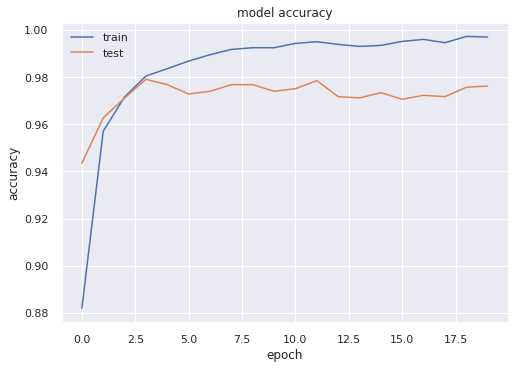

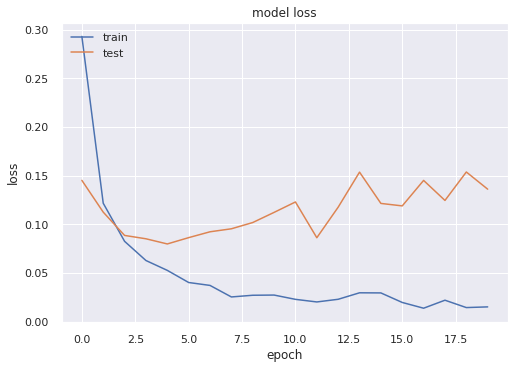

In [0]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico_genero.history['acc'])
plt.plot(historico_genero.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico_genero.history['loss'])
plt.plot(historico_genero.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<font color="#e74c3c">**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?</font>

**Resposta:**

**Acurácia do modelo:** Nota-se que o respectivo gráfico indica já na segunda época valores próximos entre treino e teste. No entanto, a continuidade com mais épocas tem por finalidade evidenciar o overfitting. Graficamente as curvas de treino e teste apresentam uma estabilidade das diferenças do modelo com acurácia acima de 97%.

**Função de erro:** Nesse gráfico, observa-se que a curva de treinamento do modelo indica que até a sétima época o gráfico apresenta uma redução significativa na função de erro, a partir desse ponto, apresentando uma estabilidade. Já no que se refere a curva do teste, percebe-se, a partir da quarta época, uma têndencia ascendente da função de erro, caracterizando um possível overfitting. Por se tratar de uma prática acadêmica, optou-se por manter o respectivo modelo.

Salve os modelos abaixo para uso em inferências mais adiante no projeto.

In [0]:
# Salvando o modelo no formato HDf5
modelo_genero.save(source_path + "modelos/modelo_genero.h5")
modelo_genero.save_weights(source_path + "pesos/modelo_genero_pesos.h5")

Os comandos a seguir são para carregar os pesos e o modelo previamente treinado.

In [0]:
# carregando o modelo no formato HDf5
modelo_genero = load_model(source_path + "modelos/modelo_genero.h5")  
modelo_genero.load_weights(source_path + "pesos/modelo_genero_pesos.h5")

> **Critério de sucesso:** acurácia do modelo, com base nas amostra de teste, superior a 95%.

### 3.4 Avaliação final

Com base em algumas amostras da base de testes, vamos inferir 6 imagens para verificarmos o desempenho do modeo.
Selecionamos 3 imagens de homens e mulheres.

Como este modelo é mais simples, ou seja, o resultado sempre vai ser a classe com maior probabilidade, não precisamos realizar a somatória dos pesos individualmente como fizemos no modelo anterior.

Assim o resultado final será obtido pela maior classe. A função ```np.argmax``` retorna a maior classe da predição realizada pelo modelo.

De acordo com o _encoding_, o índice 0 indica gênero masculino e o índice 1 o gênero feminino.

In [0]:
caminho_imagem_1 = source_path + "testes/teste-1.jpg"
caminho_imagem_2 = source_path + "testes/teste-2.png"
caminho_imagem_3 = source_path + "testes/teste-3.png"
caminho_imagem_4 = source_path + "testes/teste-4.png"
caminho_imagem_5 = source_path + "testes/teste-5.png"
caminho_imagem_6 = source_path + "testes/teste-6.png"

imagem_1 = image.load_img(caminho_imagem_1, target_size=(224, 224))
imagem_2 = image.load_img(caminho_imagem_2, target_size=(224, 224))
imagem_3 = image.load_img(caminho_imagem_3, target_size=(224, 224))
imagem_4 = image.load_img(caminho_imagem_4, target_size=(224, 224))
imagem_5 = image.load_img(caminho_imagem_5, target_size=(224, 224))
imagem_6 = image.load_img(caminho_imagem_6, target_size=(224, 224))

imagem_1_pad = carregarImagem(caminho_imagem_1)
imagem_2_pad = carregarImagem(caminho_imagem_2)
imagem_3_pad = carregarImagem(caminho_imagem_3)
imagem_4_pad = carregarImagem(caminho_imagem_4)
imagem_5_pad = carregarImagem(caminho_imagem_5)
imagem_6_pad = carregarImagem(caminho_imagem_6)

In [0]:
predicao_1 = modelo_genero.predict(imagem_1_pad)
resultado_1 = "Masculino" if np.argmax(predicao_1) == 1 else "Feminino"

predicao_2 = modelo_genero.predict(imagem_2_pad)
resultado_2 = "Masculino" if np.argmax(predicao_2) == 1 else "Feminino"

predicao_3 = modelo_genero.predict(imagem_3_pad)
resultado_3 = "Masculino" if np.argmax(predicao_3) == 1 else "Feminino"

predicao_4 = modelo_genero.predict(imagem_4_pad)
resultado_4 = "Masculino" if np.argmax(predicao_4) == 1 else "Feminino"

predicao_5 = modelo_genero.predict(imagem_5_pad)
resultado_5 = "Masculino" if np.argmax(predicao_5) == 1 else "Feminino"

predicao_6 = modelo_genero.predict(imagem_6_pad)
resultado_6 = "Masculino" if np.argmax(predicao_6) == 1 else "Feminino"

Agora vamos exibir no gráfico as imagens e as inferências realizadas.

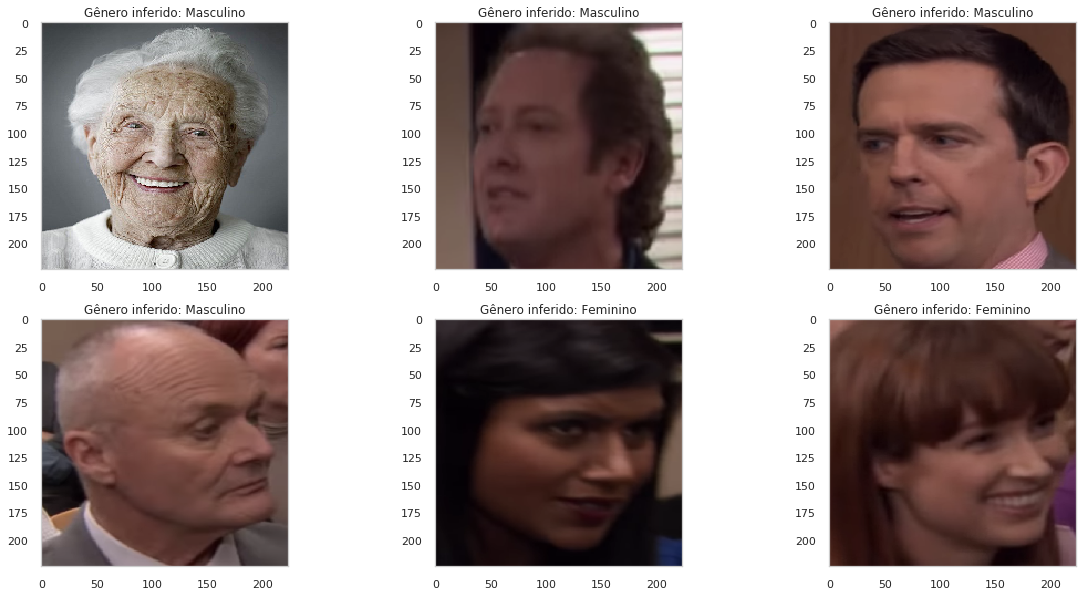

In [64]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Gênero inferido: " + resultado_1)
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Gênero inferido: " + resultado_2)
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Gênero inferido: " + resultado_3)
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Gênero inferido: " + resultado_4)
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Gênero inferido: " + resultado_5)
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Gênero inferido: " + resultado_6)
plt.imshow(imagem_6)

plt.show()

Vamos aproveitar para deixar preparado a função de predição de gênero para usarmos mais adiante.
Implemente a função abaixo para retornar "Masculino" se a classe com maior probabilidade for 1, ou "Feminino" se a maior probabilidade for a classe igual a 0.
É do mesmo jeito que fizemos anteriormente na predição de idade. Assuma que o parâmetro de entrada seja uma imagem já padronizada.

In [0]:
def predizerGenero(imagem):
    pred = modelo_genero.predict(imagem)
    result = "Masculino" if np.argmax(pred) == 1 else "Feminino"
    return result

## 4. Identificação de faces

Nesta etapa precisamos construir uma forma de extrair regiões de interesse de imagens que sejam rostos. 
Problema de reconhecimento de faces aprofundado é realizada a partir de um recorte de região de interesse. Logo, nossa estratégia agora é como extrair uma ou mais faces de uma imagem para que seja possível, posteriormente, aplicarmos os modelos que acabamos de classificar.

Vamos começar com um teste simples.

In [0]:
imagem = cv2.imread(source_path + 'testes/teste-8.png')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Pessoas')

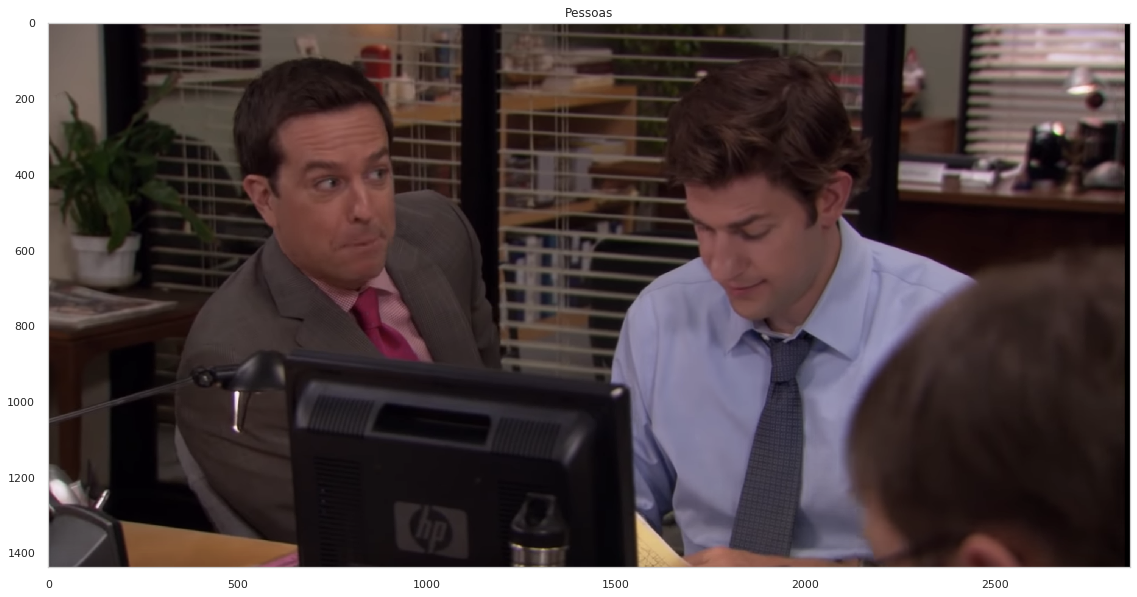

In [67]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Pessoas")

Escolha uma forma de identificar rostos de uma imagem.
Recomendamos as seguintes formas:

* Classificador em cascata de Haar
* Detector de face baseado em Hog (DLib), recomendamos utilizar o classificador de 68 pontos para maior precisão

Dada a imagem de testes apresentada, execute seu algoritmo escolhido e retorne o número de faces na variável ```faces```.

In [0]:
classificador_68_path = source_path + "modelos/shape_predictor_68_face_landmarks.dat"

classificador = dlib.shape_predictor(classificador_68_path)
detector = dlib.get_frontal_face_detector()

faces = detector(imagem, 1)

In [69]:
print("Faces encontradas: " + str(len(faces)))

Faces encontradas: 2


> **Critério de sucesso:** encontrar as 2 faces da imagem.

Com as faces identificadas, desenhe um retângulo em cada uma delas.
Para desenhar um retângulo, é necessário os seguintes dados: coordenada x, y, comprimento (w) e altura (h).

Caso utilize o detector de faces do DLib, o valor da coordenada x é equivalente ao atributo _left_ e a coordenada y é o equivalente ao atributo _top_.

O DLib é um identificador tão versátil que é capaz de identificar rostos parciais em uma imagem. No entanto, quando isso ocorre as coordenadas podem ser negativas, o que pode demandar um certo ajuste para obter o valor da região de interesse, por exemplo igualando a coordenada a 0.

Utilize o seguinte comando para desenhar um retângulo em cada face identificada.

````
cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)
````

Criando uma cópia da imagem original para anotação.

In [0]:
imagem_anotada = imagem.copy()

In [0]:
#IMPLEMENTAR
for face in faces:
    for k, d in enumerate(faces):
        cv2.rectangle(imagem_anotada, (d.left(), d.top()), (d.right(), d.bottom()), (255, 0, 255), 2)

Exibindo a imagem com os retângulos desenhados.

Text(0.5, 1.0, 'Pessoas')

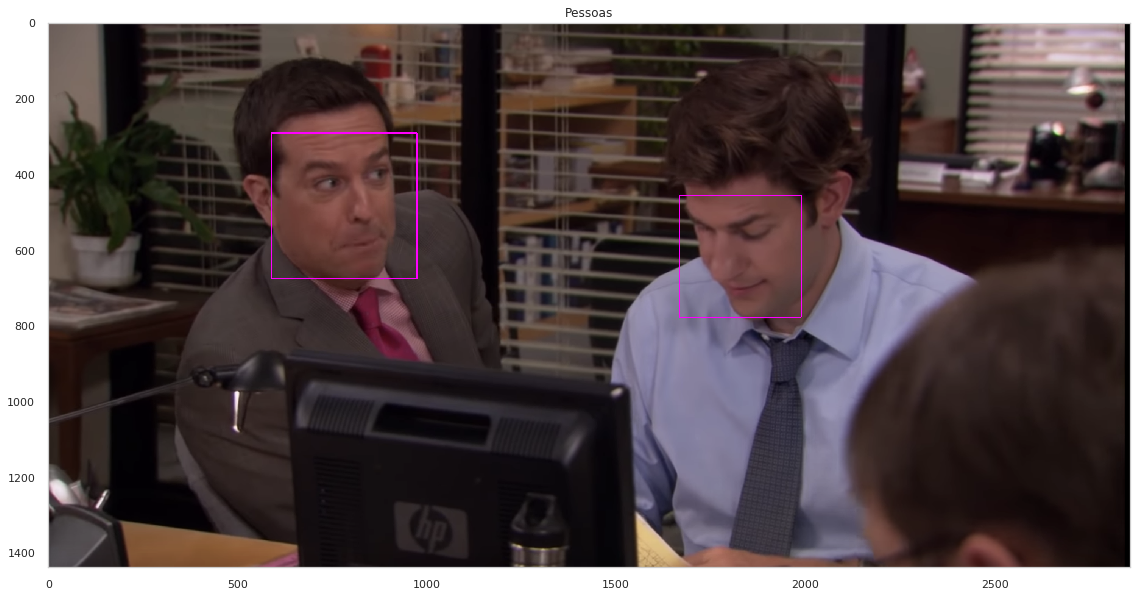

In [72]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

Uma vez que já foi definido o melhor algoritmo de identificação de faces, precisamos construir uma função que posteriormente utilizaremos no processo de processamento de vídeos.

Essa função deverá receber na entrada uma imagem colorida e retornar, na forma de lista, um dicionário com as seguintes informações: extração do ROI do rosto e as coordenadas da localização do rosto.

Exemplo de retorno:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

O atributo rosto utilizaremos para aplicarmos os modelos de reconhecimento de idade e gênero, e as coordenadas serão utilizadas para fazer os recortes nas imagens.

Com isso, a chave ```rosto``` deverá ter o _slice_ da imagem neste padrão ```imagem[y:y+h, x:x+w]``` e a chave ```coordenadas``` deverá ter a saída dos pontos (x, y, h, w) neste padrão ```[np.array(lista_coordenadas)]```.

In [0]:
def obterFaces(imagem):
    rostos = []
    faces = detector(imagem, 1)

    for face in faces:
        x = face.left()
        y = face.top()
        w = face.width()
        h = face.height()

        rostos.append({ "coordenadas": [np.array((x, y, h, w))], "rosto": imagem[y:y+h, x:x+w] })

    return rostos

Vamos aplicar um teste com a imagem anterior (variável ```imagem```).

In [74]:
rostos = obterFaces(imagem)
rostos

[{'coordenadas': [array([589, 290, 386, 386])], 'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],
  
         [[38, 20, 19],
          [39, 21, 19],
          [41, 22, 20],
          ...,
          [36, 18, 13],
          [37, 20, 15],
          [39, 22, 17]],
  
         [[37, 19, 18],
          [39, 20, 18],
          [41, 22, 20],
          ...,
          [36, 18, 13],
          [37, 20, 14],
          [39, 21, 16]],
  
         ...,
  
         [[57, 47, 49],
          [58, 47, 49],
          [58, 48, 49],
          ...,
          [61, 49, 48],
          [62, 50, 49],
          [63, 51, 50]],
  
         [[58, 48, 50],
          [59, 48, 50],
          [59, 49, 50],
          ...,
          [63, 51, 50],
          [63, 51, 50],
          [62, 50, 49]],
  
         [[58, 48, 50],
          [59, 49, 51],
          [60, 49, 50],
          ...,
          [63, 51, 50],
  

> **Critério de sucesso:** retornar 2 valores (da lista) com coordenadas e rosto para cada face identificada. Exemplo:


```
[{'coordenadas': [array([534, 20,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)},
  {'coordenadas': [array([222, 13,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)}]
```

Agora vamos testar se os parâmetros estão funcionando adequadamente.

Primeiro a imagem do rosto.

Text(0.5, 1.0, 'Pessoas')

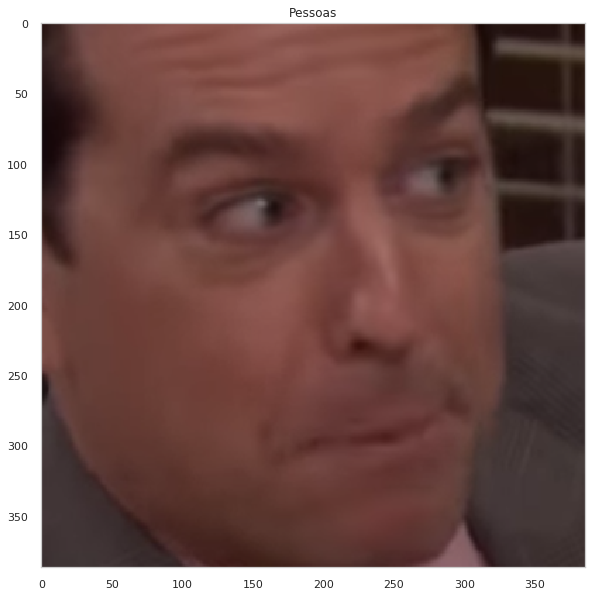

In [75]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[0]["rosto"])
plt.title("Pessoas")

O próximo passo são as coordenadas. Para simplificar, vamos desenhar um retângulo na imagem original com estes pontos.

Text(0.5, 1.0, 'Pessoas')

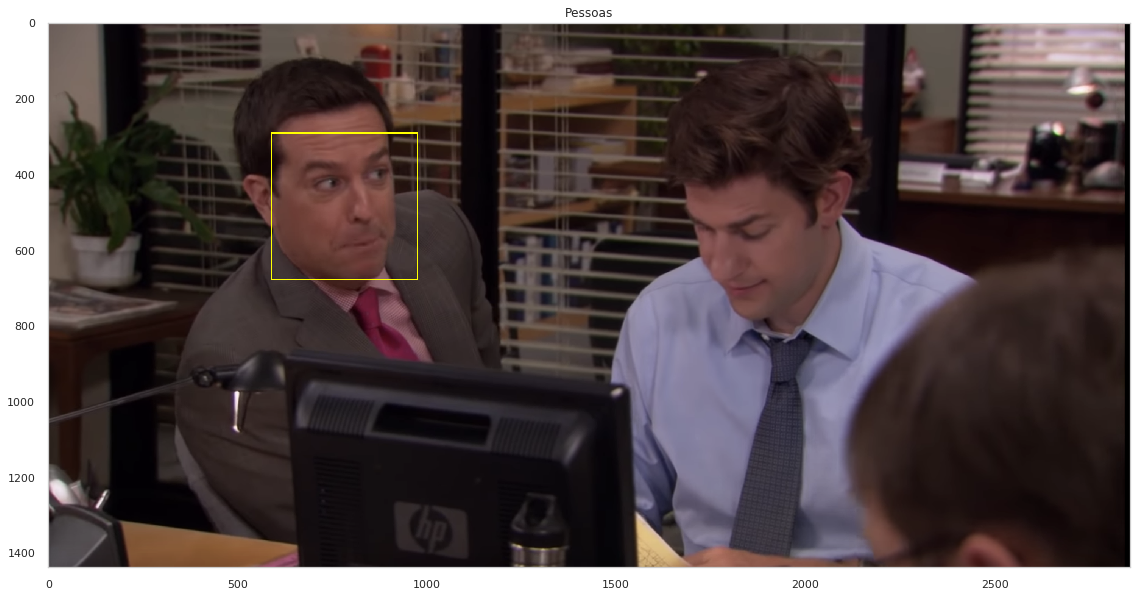

In [76]:
imagem_anotada = imagem.copy()

for (x,y,w,h) in rostos[0]["coordenadas"]:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

### 4.1 Padronização de tamanho de imagem

Adiante, quando aplicarmos a classificação dos rostos, precisaremos antes padronizar a imagem para o tamanho que o modelo recebe na camada de entrada bem como a normalização dos pixels da imagem, ou seja, ao invés de estar no formato de intensidade de pixel de 0 a 255, deve estar representado entre 0 e 1.

As implementações deverão ser as seguintes:

1. ```IMPLEMENTAR 1```: redimensionar a imagem para o tamanho da camada de entrada. Utilize uma interpolação adequada para não perder qualidade de imagem.
2. ```IMPLEMENTAR 2```: normalizar a intensidade de pixel da imagem para 0 e 1 e não 0 a 255, que é o padrão.

As demais instruções seguem inalteradas.

In [0]:
def padronizarROI(imagem):
    # IMPLEMENTAR 1
    imagem = cv2.resize(imagem, (224,224))
    
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    
    # IMPLEMENTAR 2
    imagem = np.float32(imagem)/255.0
    
    return imagem

Agora, vamos avançar para a identificação de objetos.

## 5. Identificação de objetos

Além de identificarmos as pessoas, precisamos também identificar diferentes objetos.
Uma forma de alcançarmos tal objetivo é utilizar um modelo já treinado com diversos objetos treinados.

O modolo Yolov3, por exemplo, possui 80 diferentes objetos em seu modelo, servindo muito bem para o propósito do desafio.

### 5.1 Configurando o modelo Yolov3

Primeiramente baixe os pesos diretamente no site do Darknet, neste [link](https://pjreddie.com/media/files/yolov3.weights). Copie o arquivo ```yolov3.weights``` para a pasta pesos.
Confira o arquivo ```yolo-classes/coco.anmes```. Estas são as classes de todos os objetos que são possíveis identificar.
Por fim, verifique se o arquivo ```config/yolov3.cfg``` está presente. Não é necessário ajustar nenhum parâmetro nele.

In [0]:
# Carregar os labels do conjunto de dados Coco
label_path = source_path + "yolo-classes/coco.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path = source_path + "pesos/yolov3.weights"
config_path = source_path + "config/yolov3.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Se o código carregou as configurações sem erros, estamos prontos para avançar.

Os valores de confiança e supressão não máxima são atributes importantes para o processo de detecção de objetos. Escolha valores adequados que permitam a detecção aceitável e com valores próximos os critérios de sucesso apresentandos mais adiante.

Os valores precisam ser numéricos fracionários. Sendo que 1 é igual a 100%. Valores médios costumam apresentar performance razoável.

In [0]:
conf_threshold = 0.5
nms_threshold = 0.5

<font color="#e74c3c">**Pergunta:** Qual é a influência do parâmetro de confiança e supressão não máxima na performance do modelo?</font>

**Resposta:**

**Threshold de confiança:** 
considerando o contexto de optar por um limite de confiança baixo, entende-se que há uma maior chance de erro no reconhecimento do objeto, enquanto que, assumindo-se um limite de confiança alto, há maior chance do não reconhecimento do objeto. Busca-se valores médios para garantir melhor performance.

**Supressão de não máxima:**
Utilizar os filtros para redução de cristas largas (afinamento das bordas) em torno dos máximos locais, permite obter uma imagem com menos características a serem analisadas. Por sua vez, sua influência é notada na redução os ruídos e dos falsos positivos para detecção dos gradientes da imagem.

### 5.2 Obtendo região de interesse e coordenadas

De forma semelhante que foi feito na identificação de faces, vamos fazer para a identificação de objetos.
Na função abaixo vamos implementar um algoritmo que retornará em um dicionário os valores do recorte da imagem, o que chamamos de região de interesse e suas coordenadas x, y, w e h.

A entrada da função é uma imagem colorida e uma lista de objetos para identificar, no formato de lista.
Sua saída, é uma lista de objetos no seguinte formato:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'objeto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

Onde ```coordenadas``` é uma lista das coordenadas x, y, w e h no formato array, igual ao que foi apresentado anteriormente: ```[np.array(lista_coordenadas)]```. E ```objeto``` é a região de interesse do objeto extraído, igual ao que foi apresentado anteriormente: ```imagem[y:y+h, x:x+w]```.

In [0]:
def obter_objetos(imagem, lista_objetos):
    
    (H, W) = imagem.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    objetos = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            
            if labels[classIDs[i]] in lista_objetos:
                print("Identificado " + text)
                
                # IMPLEMENTAR
                item = { "objeto": imagem[y:y+h, x:x+w], "coordenadas": [np.array((x, y, w, h))] }
                
                objetos.append(item)

    return objetos

Vamos utilizar outra imagem de testes para validar o algoritmo.

In [0]:
imagem_inferencia = cv2.imread(source_path + "testes/teste-9.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

Na variável ```lista_objetos``` preecha com uma lista de Strings com os valores "pessoa" e "gravata" que são os objetos a serem identificados.

In [0]:
# IMPLEMENTAR
lista_objetos = ["pessoa", "gravata"]

Execute a função com a lista definida.

In [83]:
objetos = obter_objetos(imagem_inferencia, lista_objetos)

Identificado pessoa: 0.9927
Identificado pessoa: 0.9665
Identificado pessoa: 0.9440
Identificado pessoa: 0.9264
Identificado pessoa: 0.9150
Identificado gravata: 0.7960
Identificado pessoa: 0.7253


Para nos certificamos que a identificação está correta, vamos desenhar um retângulo delimitador na imagem e verificar como foi a identificação.

Neste caso vamos utilizar o parâmetro ```coordenadas``` do retorno da função para cada objeto identificado.

In [0]:
imagem_anotada = imagem_inferencia.copy()
for obj in objetos:
    for (x,y,w,h) in obj["coordenadas"]:
        cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

Text(0.5, 1.0, 'Imagem Inferida')

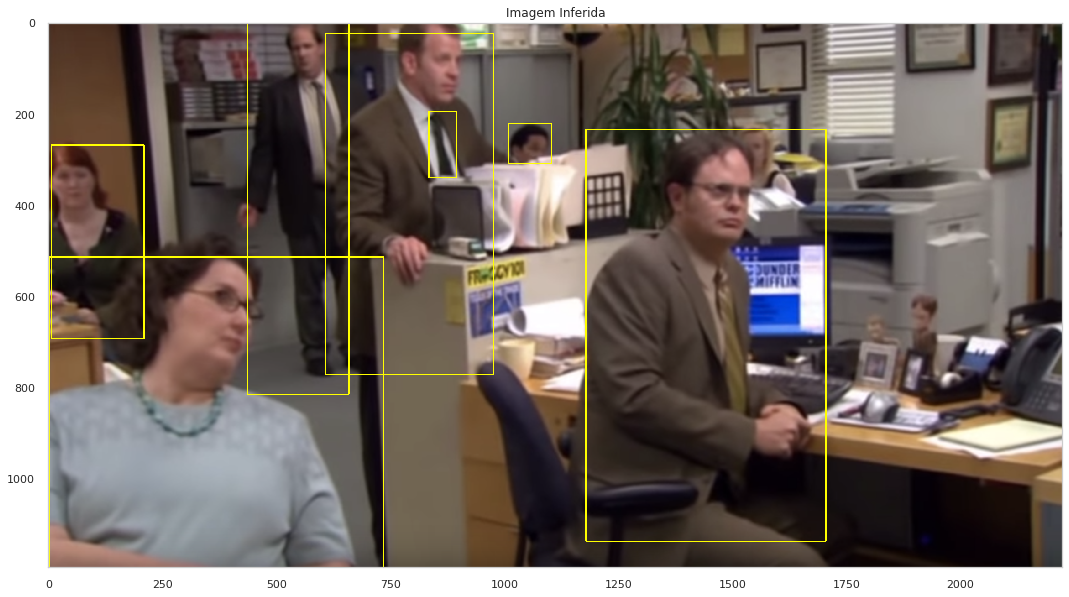

In [85]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Imagem Inferida")

Vamos dar uma olhada em 3 regiões de interesse detectadas.
Lembrando que estas regiões são imagens, podemos renderizá-las diretamente no Pyplot.

Text(0.5, 1.0, 'Região de interesse #1')

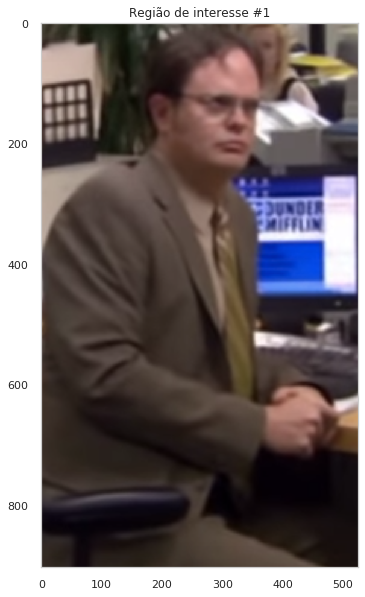

In [86]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[0]["objeto"])
plt.title("Região de interesse #1")

Text(0.5, 1.0, 'Região de interesse #1')

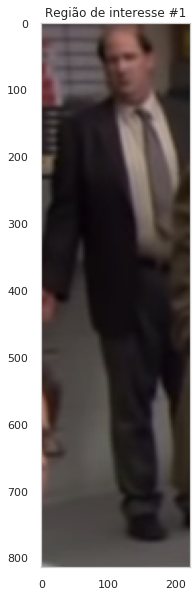

In [87]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[1]["objeto"])
plt.title("Região de interesse #1")

Text(0.5, 1.0, 'Região de interesse #1')

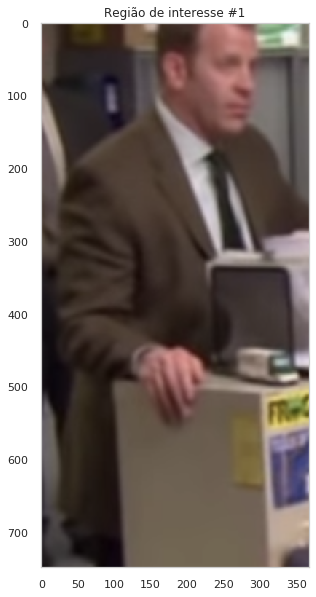

In [88]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[2]["objeto"])
plt.title("Região de interesse #1")

Perfeito, agora já estamos prontos para juntar todas as peças e começar nossa auditoria.

## 6. Auditoria automática em vídeo

Esta é a parte final do projeto.
Vamos fazer um checkpoint até aqui para ter certeza de que fizemos com sucesso os passos anteriores.

* <input type="checkbox" disabled checked> Modelo de detecção de idades treinado
* <input type="checkbox" disabled checked> Modelo de detecção de idades salvo
* <input type="checkbox" disabled checked> Modelo de detecção de idades carregado
* <input type="checkbox" disabled checked> Função de detecção de idades
* <input type="checkbox" disabled checked> Modelo de detecção de gênero treinado
* <input type="checkbox" disabled checked> Modelo de detecção de gênero salvo
* <input type="checkbox" disabled checked> Modelo de detecção de gênero carregado
* <input type="checkbox" disabled checked> Função de detecção de gênero
* <input type="checkbox" disabled checked> Função de padronização de imagens
* <input type="checkbox" disabled checked> Função de extração de faces
* <input type="checkbox" disabled checked> Função de extração de objetos

O que precisamos identificar no vídeo de auditoria:

* Homens com mais de 45 anos
* Mulheres com menos de 45 anos
* Objetos _computador portátil, celular, teclado, tv _ e _controle remoto_.

Vamos começar definindo a lista de objetos.

In [0]:
lista_objetos = [None]

Nesta parte vamos reunir tudo o que fizemos até aqui.
O algoritmo irá abrir um vídeo e, frame a frame, analisar seu conteúdo.
Após a instrução ```if is_capturing``` iremos implementar as verificações.

A execução abaixo pode demorar, pois será analisado individualmente cada frame do vídeo.

O que precisamos fazer:

* ```IMPLEMENTAR 1```: obter as faces de uma imagem. Neste caso receberamos uma lista de rostos no padrão que já vimos, ou seja, uma lista de ```rosto``` e ```coordenadas```.

* ```IMPLEMENTAR 2```: obter as a face de um item e padronizar. Lembre-se de utilizar a função de padronização que foi desenvolvida anteriormente, que tem por finalidade ajustar o tamanho da imagem e também normalizá-la.

* ```IMPLEMENTAR 3```: executar as funções de identificar a idade e gênero para a tomada de decisões de coleta de evidências.

* ```IMPLEMENTAR 4```: criar as regras de armazenamento de evidências para pessoas. Consulte as regras no início do projeto sobre quais os gêneros e idades de interesse. As regiões de interesse nesse caso, os rostos, deverão ser salvos individualmente na pasta ```resultado/homem``` e ```resultado/mulher```.

* ```IMPLEMENTAR 5```: criar as regras de armazenamento de evidências para objetos. As regiões de interesse nesse caso, os objetos, deverão ser salvos individualmente na pasta ```resultado/objetos```.

In [0]:
#cam.release()
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
cam = cv2.VideoCapture(source_path + "videos/video-1.avi")
contador = 0 
try:
    while(True):
        contador += 1
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            # IMPLEMENTAR 1
            # Obter Faces
            faces = obterFaces(imagem)
            
            for idx, face in enumerate(faces):
                print("Encontrado " + str(len(faces)) + " rostos...")
                
                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
                imagem_rosto = face["rosto"]

                try:
                  rosto_padronizado = padronizarROI(imagem_rosto)
                  
                  # IMPLEMENTAR 3
                  # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                  
                  genero = predizerGenero(rosto_padronizado)
                  idade = predizerIdade(rosto_padronizado)
                  
                  print("Gênero: " + genero + ", idade: " + str(idade))
                  
                  # IMPLEMENTAR 4
                  # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                  # de acordo com o identificação (resultado/homem, resultado/mulher)
                  # Cuidado para não sobrescrever as imagens

                  resultado_path_homem = source_path + "resultado/homem/"
                  resultado_path_mulher = source_path + "resultado/mulher/"
                  
                  if (genero == 'Masculino' and idade > 45):
                    #usar a variável contador para concatenar no nome da imagem para não repetir
                    plt.imsave(resultado_path_homem + 'homem_' + str(contador) + '.png', 
                              cv2.cvtColor(imagem_rosto, cv2.COLOR_BGR2RGB))
                  elif (genero == 'Feminino' and idade < 45):
                    plt.imsave(resultado_path_mulher + 'mulher_' + str(contador) + '.png', 
                              cv2.cvtColor(imagem_rosto, cv2.COLOR_BGR2RGB))
                except:
                  print('Erro ao processar imagem.')
                    
            objetos = obter_objetos(imagem, ["computador", "telefone"])
            resultado_path_objetos = source_path + "resultado/objetos/"

            # IMPLEMENTAR 5
            # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
            # de acordo com o identificação (resultado/objetos)
            # Cuidado para não sobrescrever as imagens
            
            if (objetos):
              for obj in objetos:
                #usar a variável contador para concatenar no nome da imagem para não repetir
                plt.imsave(resultado_path_objetos + 'obj_' + str(contador) + '.png', cv2.cvtColor(obj["objeto"], cv2.COLOR_BGR2RGB))

            # cv2_imshow(imagem) # Note cv2_imshow, not cv2.imshow
            clear_output()
                    
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

<font color="#e74c3c">Justificativa quanto ao critério de sucesso:</font>

Devido ao número reduzido de dados para fazer o treinamento, o reconhecimento de gênero está com um alto viés para o gênero masculino e a acurácia da predição de idade está baixa. Desse modo, o critério de sucesso não poderá ser alcançado.

> **Critério de sucesso:** identificação de 180 imagens de homens. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 190 imagens de mulheres. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 680 imagens de objetos selecionados. Como um mesmo objeto pode aparecer em diferentes frames é comum repetir as imagens

<font color="#e74c3c">7. Conclusões finais</font>

Com base nesta jornada de construção de modelos, análises de regiões de interesse e processamento de vídeo, comente quais seriam os principais pontos de melhoria para alcançar resultados melhores em todas as etapas.

**Resposta: **

Diante do presente estudo, identificam-se sugestões para alcançar resultados melhores passando por técnicas e modelos nas etapas de pré-processamento e processamento do dataset.

1.   **Classificação do dataset em categorias conforme faixa etária:** por exemplo: criança, jovem, adulto e idoso. Isso permite a especializacão do modelo durante a aprendizagem.

2.   **Separação entre treino, teste e validação:** por exemplo: incluir no *resampling* a etapa de validação, aplicando o bootstrap ou cross-validation (K-Fold).
Essas técnicas permitem a redução do tempo de processamento computacional e garante a estimativa da precisão das amostras.

3.   **Redução do número de épocas:** por exemplo: considerar um intervalo de 2 a 4 épocas. Durante a análise, os gráficos de acurácia e de função de erro indicam esse intervalo para convergência entre as curvas de aprendizagem do treino e do teste, eliminando overfitting.

4.   **Utilização de algoritmos genéticos como técnica de busca**: por exemplo: otimização dos hiperparâmetros da rede neural. Permitem o processamento paralelo, não utilizam informações locais, sendo portanto, menos sensíveis aos máximos locais e não são afetados por descontinuidades da função a ser otimizada.